In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e16/sample_submission.csv
/kaggle/input/playground-series-s3e16/train.csv
/kaggle/input/playground-series-s3e16/test.csv


In [39]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from catboost import CatBoostRegressor, Pool, cv
from sklearn.metrics import mean_squared_error
from feature_engine.outliers import Winsorizer 
from sklearn.pipeline import Pipeline
import optuna
from xgboost import XGBRegressor

In [88]:
train = pd.read_csv('/kaggle/input/playground-series-s3e16/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e16/test.csv')

train['dataset_type'] = 'train'
test['dataset_type'] = 'test'

all_data = pd.concat([train, test])

In [89]:
train.head(5)

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,dataset_type
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9,train
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8,train
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9,train
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11,train
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8,train


In [90]:
train.shape

(74051, 11)

In [91]:
train.dtypes

id                  int64
Sex                object
Length            float64
Diameter          float64
Height            float64
Weight            float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Age                 int64
dataset_type       object
dtype: object

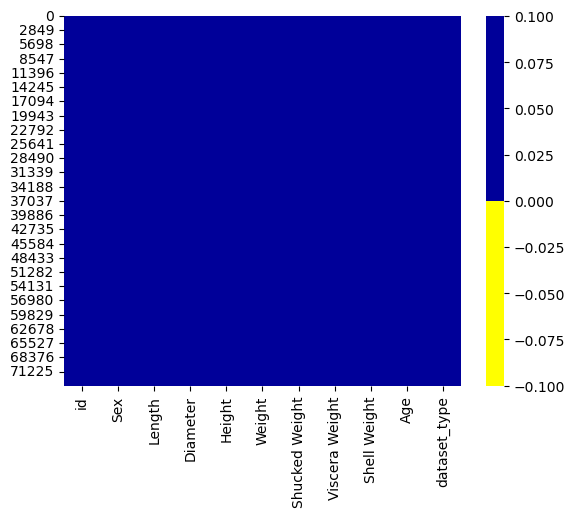

In [92]:
cols = train.columns[:11]
# желтый - пропущены, синий - не пропущены
colours = ['#ffff00', '#000099']
sns.heatmap(train[cols].isna(), cmap=sns.color_palette(colours))
None

Пропусков в данных нет

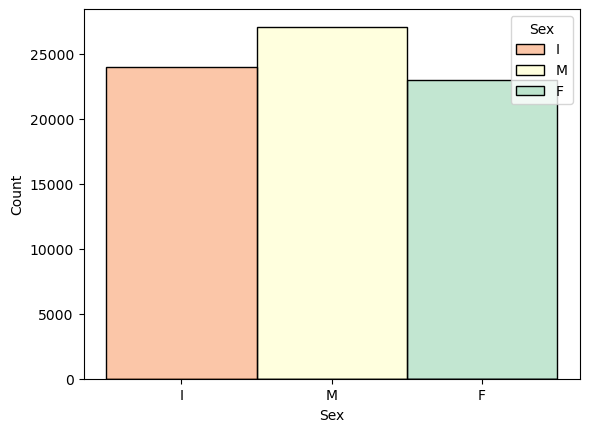

In [93]:
sns.histplot(data=train, x="Sex", hue = 'Sex', kde=True, palette = "Spectral")
None

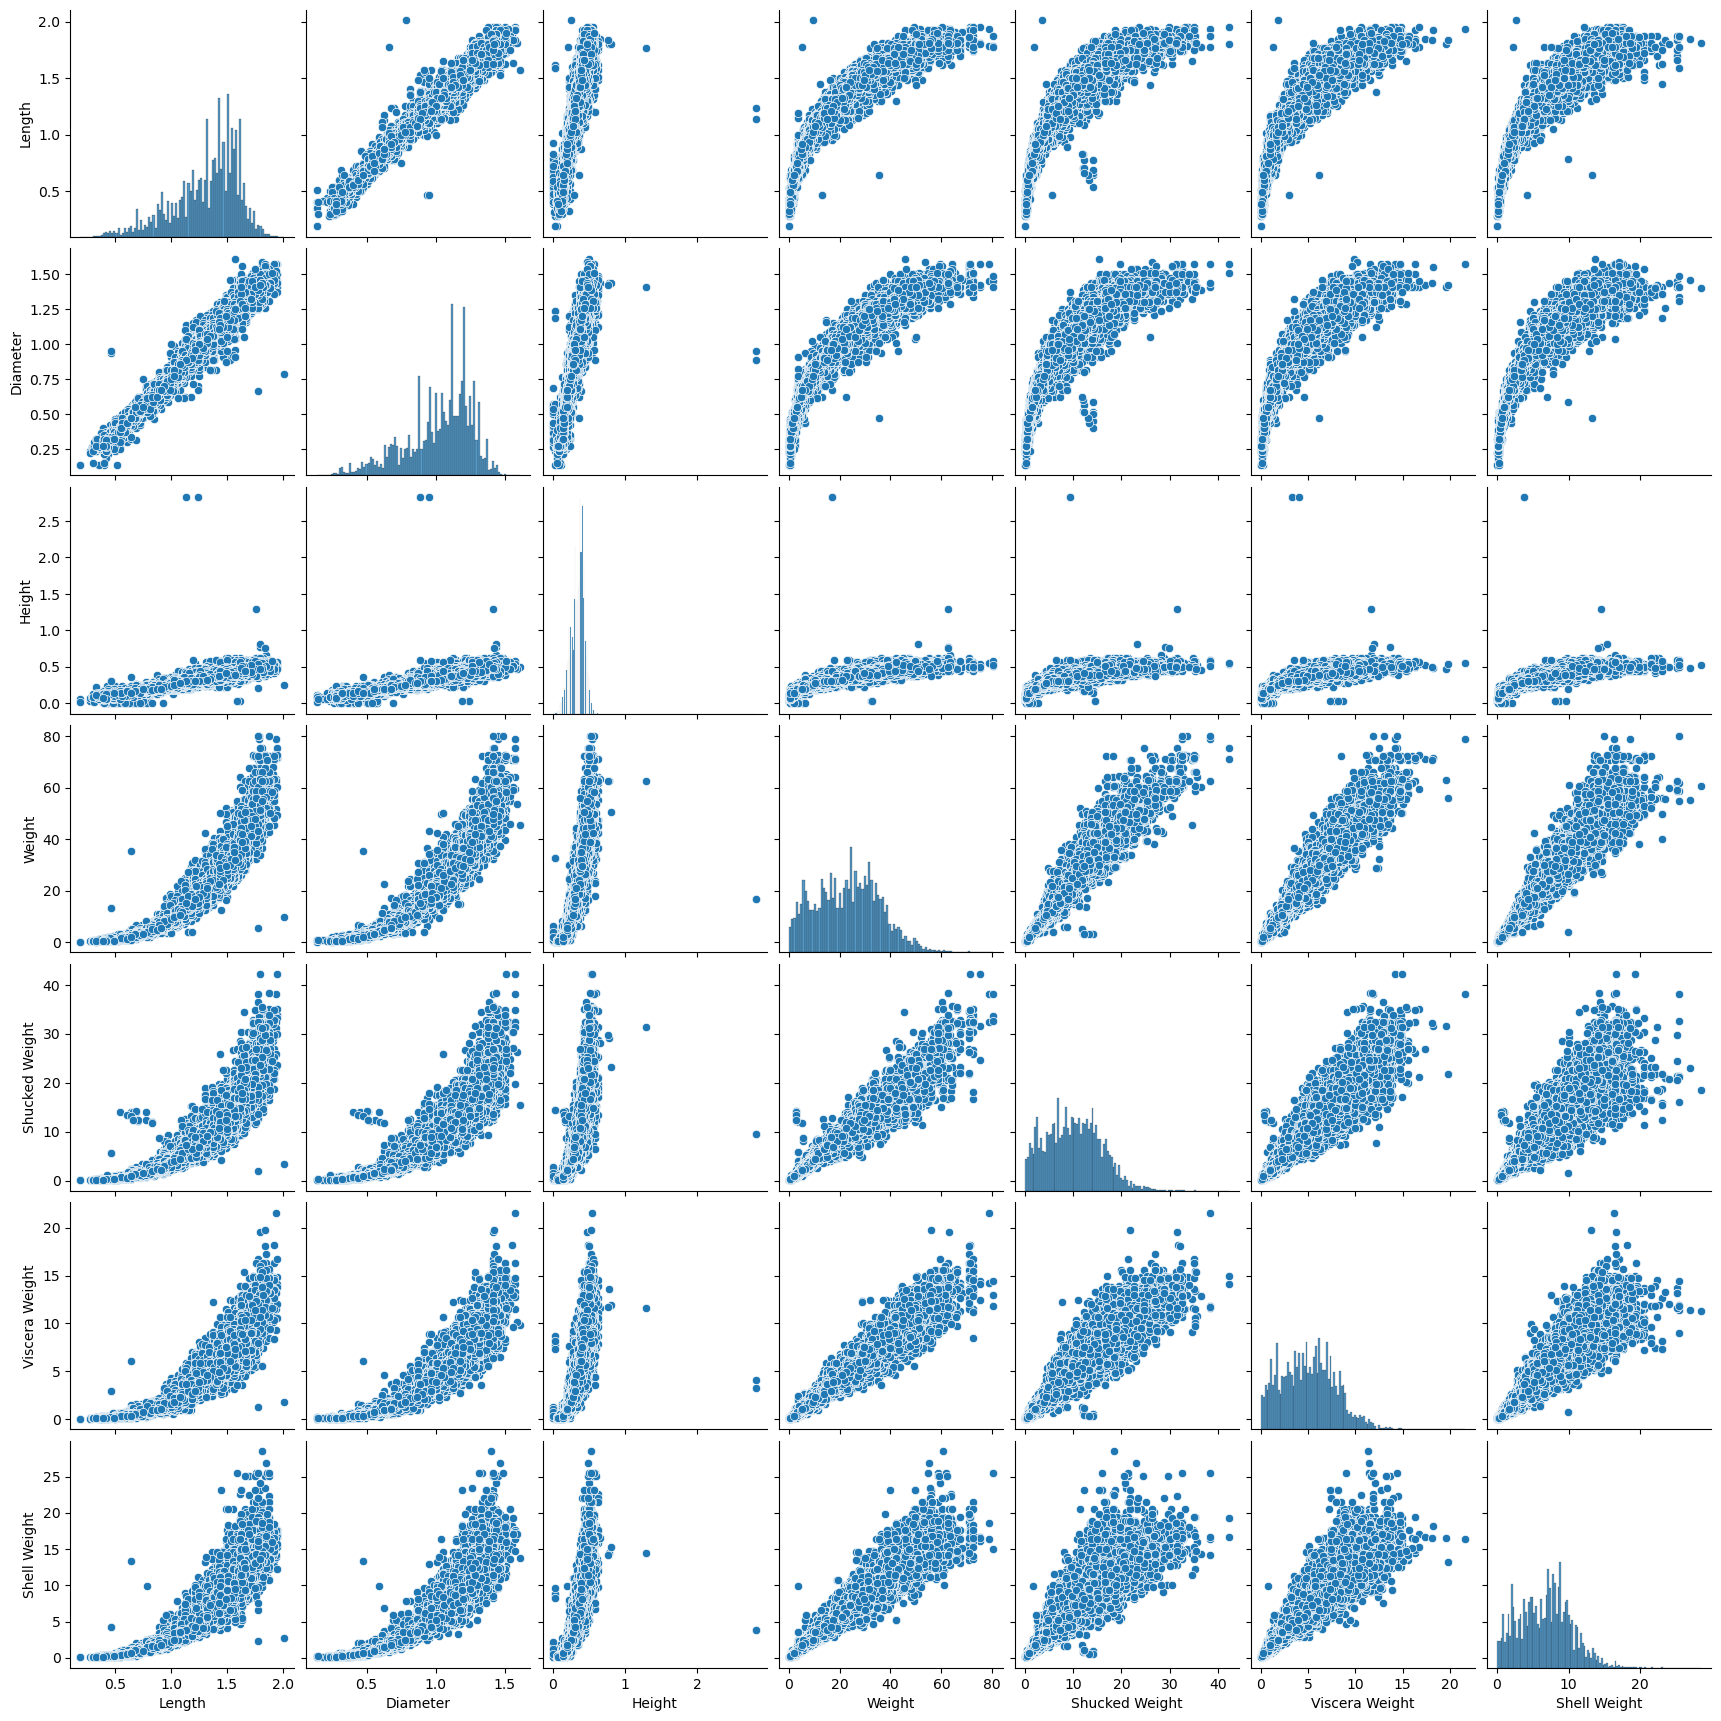

In [94]:
sns.pairplot(train.drop(['id', 'Sex', 'dataset_type', 'Age'], axis=1))
plt.show()

In [95]:
X = train.drop(['id', 'dataset_type', 'Age'], axis=1)
#X = train.drop(['id', 'dataset_type', 'Age'], axis=1)
y = train['Age']

In [96]:
count_columns = X.select_dtypes(include=np.number).columns.tolist()
cat_columns = X.select_dtypes(exclude=np.number).columns.tolist()

In [97]:
def pipeline_cat_boost(*params):

    capper = Winsorizer(capping_method='iqr', tail='both', variables=count_columns)
    scaler = StandardScaler()
    encoder = OneHotEncoder(drop='first')
    
    transformers = [
        ('capper', capper, count_columns),
        ('scaler', scaler, count_columns),
        ('encoder', encoder, cat_columns),
    ]
    
    ct = ColumnTransformer(transformers, remainder='drop')
    
    model = CatBoostRegressor(*params, random_state=42)
    
    pipeline = Pipeline([('ct', ct), ('cat', model)])
    
    return pipeline
    
def pipeline_xgb_boost():
    
    capper = Winsorizer(capping_method='iqr', tail='both', variables=count_columns)
    scaler = StandardScaler()
    encoder = OneHotEncoder(drop='first')
    
    transformers = [
        ('capper', capper, count_columns),
        ('scaler', scaler, count_columns),
        ('encoder', encoder, cat_columns),
    ]
    
    ct = ColumnTransformer(transformers, remainder='drop')
    
    model = XGBRegressor()
    
    pipeline = Pipeline([('ct', ct), ('xgb', model)])
    
    return pipeline
    

In [98]:
params_grid_cat = {
                    'cat__iterations':                 optuna.distributions.IntDistribution(800, 1000),
                    'cat__learning_rate':              optuna.distributions.FloatDistribution(0.1, 0.3),
                    'cat__depth':                      optuna.distributions.IntDistribution(4, 11),
                    'cat__min_data_in_leaf':           optuna.distributions.IntDistribution(3, 11),
                    'cat__leaf_estimation_iterations': optuna.distributions.IntDistribution(9, 15),
}

params_grid_xgb = {
                    'xgb__max_depth': optuna.distributions.IntDistribution(4, 11),
                    'xgb__max_leaves': optuna.distributions.IntDistribution(5, 15),
                    'xgb__learning_rate': optuna.distributions.FloatDistribution(0.1, 0.3),
}

In [99]:
pipelines = {'cat': pipeline_cat_boost(), 'xgb': pipeline_xgb_boost()}
all_params = {'cat': params_grid_cat, 'xgb': params_grid_xgb} 

In [100]:
find_parameters = {'cat': 0, 'xgb': 0}

In [101]:
for model_type, model in pipelines.items():
    
    params = all_params[model_type]
    pipeline = pipelines[model_type]
    
    optuna_search = optuna.integration.OptunaSearchCV(
        pipeline,
        params,
        cv=3,
        n_trials=10000,
        timeout=60,
        random_state=42,
        scoring='neg_mean_absolute_error',
        error_score='raise',
        verbose=False,
    )

    optuna_search.fit(X, y)

    print(f'Тест модели {model_type}')
    print("Количество запусков: {}".format(len(optuna_search.study_.trials)))
    print("Лучший результат:")

    trial = optuna_search.study_.best_trial

    print("MAE метрика: {}".format(trial.value))

    find_parameters[model_type] = optuna_search.best_params_
    print(find_parameters)

/tmp/ipykernel_32/1246982759.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-06-08 10:57:13,794] A new study created in memory with name: no-name-92cc8dd2-2daa-485b-b9b9-54cce6f8cee3


0:	learn: 2.8395454	total: 10.7ms	remaining: 9.56s
1:	learn: 2.6279043	total: 20ms	remaining: 8.88s
2:	learn: 2.4830997	total: 29ms	remaining: 8.58s
3:	learn: 2.3843721	total: 38.4ms	remaining: 8.52s
4:	learn: 2.3196595	total: 48.1ms	remaining: 8.53s
5:	learn: 2.2755453	total: 56.9ms	remaining: 8.4s
6:	learn: 2.2426759	total: 67.8ms	remaining: 8.56s
7:	learn: 2.2165900	total: 75.3ms	remaining: 8.31s
8:	learn: 2.2011376	total: 82.5ms	remaining: 8.09s
9:	learn: 2.1844658	total: 90.9ms	remaining: 8.01s
10:	learn: 2.1745747	total: 97.8ms	remaining: 7.83s
11:	learn: 2.1651982	total: 107ms	remaining: 7.83s
12:	learn: 2.1544260	total: 116ms	remaining: 7.81s
13:	learn: 2.1453152	total: 124ms	remaining: 7.77s
14:	learn: 2.1367245	total: 133ms	remaining: 7.77s
15:	learn: 2.1296920	total: 142ms	remaining: 7.76s
16:	learn: 2.1241441	total: 151ms	remaining: 7.77s
17:	learn: 2.1212468	total: 158ms	remaining: 7.65s
18:	learn: 2.1177039	total: 166ms	remaining: 7.64s
19:	learn: 2.1140772	total: 176ms	r

[I 2023-06-08 10:57:38,527] Trial 0 finished with value: -1.4222417012755668 and parameters: {'cat__iterations': 891, 'cat__learning_rate': 0.26652640646299197, 'cat__depth': 4, 'cat__min_data_in_leaf': 5, 'cat__leaf_estimation_iterations': 12}. Best is trial 0 with value: -1.4222417012755668.


0:	learn: 2.9773214	total: 10.8ms	remaining: 9.25s
1:	learn: 2.8225806	total: 21.5ms	remaining: 9.2s
2:	learn: 2.6949417	total: 30.9ms	remaining: 8.8s
3:	learn: 2.5947698	total: 41.9ms	remaining: 8.95s
4:	learn: 2.5107927	total: 52.1ms	remaining: 8.89s
5:	learn: 2.4453084	total: 61.5ms	remaining: 8.74s
6:	learn: 2.3921605	total: 71.3ms	remaining: 8.68s
7:	learn: 2.3501706	total: 82.6ms	remaining: 8.78s
8:	learn: 2.3155862	total: 93.2ms	remaining: 8.8s
9:	learn: 2.2855365	total: 103ms	remaining: 8.78s
10:	learn: 2.2612176	total: 113ms	remaining: 8.75s
11:	learn: 2.2394097	total: 125ms	remaining: 8.79s
12:	learn: 2.2208999	total: 134ms	remaining: 8.7s
13:	learn: 2.2068565	total: 144ms	remaining: 8.7s
14:	learn: 2.1934114	total: 153ms	remaining: 8.62s
15:	learn: 2.1819574	total: 163ms	remaining: 8.58s
16:	learn: 2.1727266	total: 173ms	remaining: 8.56s
17:	learn: 2.1655297	total: 182ms	remaining: 8.5s
18:	learn: 2.1576727	total: 191ms	remaining: 8.43s
19:	learn: 2.1510099	total: 200ms	rema

[I 2023-06-08 10:58:04,619] Trial 1 finished with value: -1.4119769631209251 and parameters: {'cat__iterations': 859, 'cat__learning_rate': 0.1424852547984445, 'cat__depth': 5, 'cat__min_data_in_leaf': 4, 'cat__leaf_estimation_iterations': 11}. Best is trial 1 with value: -1.4119769631209251.


0:	learn: 2.7613840	total: 23.9ms	remaining: 20.8s
1:	learn: 2.5087489	total: 39.5ms	remaining: 17.2s
2:	learn: 2.3610344	total: 56.6ms	remaining: 16.4s
3:	learn: 2.2653585	total: 74.5ms	remaining: 16.1s
4:	learn: 2.2059439	total: 91.3ms	remaining: 15.8s
5:	learn: 2.1704066	total: 109ms	remaining: 15.7s
6:	learn: 2.1442094	total: 126ms	remaining: 15.5s
7:	learn: 2.1259869	total: 142ms	remaining: 15.3s
8:	learn: 2.1137550	total: 155ms	remaining: 14.9s
9:	learn: 2.1023002	total: 170ms	remaining: 14.6s
10:	learn: 2.0940217	total: 185ms	remaining: 14.4s
11:	learn: 2.0884757	total: 201ms	remaining: 14.4s
12:	learn: 2.0815978	total: 215ms	remaining: 14.2s
13:	learn: 2.0755113	total: 231ms	remaining: 14.2s
14:	learn: 2.0706356	total: 248ms	remaining: 14.1s
15:	learn: 2.0667060	total: 265ms	remaining: 14.1s
16:	learn: 2.0618255	total: 280ms	remaining: 14s
17:	learn: 2.0588090	total: 295ms	remaining: 14s
18:	learn: 2.0568317	total: 309ms	remaining: 13.8s
19:	learn: 2.0545744	total: 324ms	remain

[I 2023-06-08 10:58:49,935] Trial 2 finished with value: -1.5005041303307962 and parameters: {'cat__iterations': 870, 'cat__learning_rate': 0.29985017206801895, 'cat__depth': 8, 'cat__min_data_in_leaf': 5, 'cat__leaf_estimation_iterations': 11}. Best is trial 1 with value: -1.4119769631209251.


0:	learn: 2.9773304	total: 13.9ms	remaining: 11.9s
1:	learn: 2.8249451	total: 26.5ms	remaining: 11.3s
2:	learn: 2.6988056	total: 39.8ms	remaining: 11.3s
3:	learn: 2.5938701	total: 54.2ms	remaining: 11.6s
4:	learn: 2.5083206	total: 67.2ms	remaining: 11.5s
5:	learn: 2.4392350	total: 81ms	remaining: 11.5s
6:	learn: 2.3840648	total: 95.2ms	remaining: 11.6s
7:	learn: 2.3422745	total: 106ms	remaining: 11.3s
8:	learn: 2.3109665	total: 118ms	remaining: 11.2s
9:	learn: 2.2795706	total: 131ms	remaining: 11.1s
10:	learn: 2.2528174	total: 142ms	remaining: 11s
11:	learn: 2.2327624	total: 155ms	remaining: 10.9s
12:	learn: 2.2159722	total: 166ms	remaining: 10.8s
13:	learn: 2.2015597	total: 178ms	remaining: 10.7s
14:	learn: 2.1882121	total: 188ms	remaining: 10.6s
15:	learn: 2.1780323	total: 200ms	remaining: 10.5s
16:	learn: 2.1677619	total: 211ms	remaining: 10.5s
17:	learn: 2.1606837	total: 225ms	remaining: 10.5s
18:	learn: 2.1532670	total: 240ms	remaining: 10.6s
19:	learn: 2.1457948	total: 255ms	rema

/tmp/ipykernel_32/1246982759.py:6: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = optuna.integration.OptunaSearchCV(
[I 2023-06-08 10:59:01,420] A new study created in memory with name: no-name-bddd9525-a6c9-4c2b-a3af-276424ef2ce8


853:	learn: 1.8739066	total: 10.7s	remaining: 62.7ms
854:	learn: 1.8737014	total: 10.7s	remaining: 50.1ms
855:	learn: 1.8734893	total: 10.7s	remaining: 37.6ms
856:	learn: 1.8733319	total: 10.7s	remaining: 25.1ms
857:	learn: 1.8732589	total: 10.8s	remaining: 12.5ms
858:	learn: 1.8731504	total: 10.8s	remaining: 0us
Тест модели cat
Количество запусков: 3
Лучший результат:
MAE метрика: -1.4119769631209251
{'cat': {'cat__iterations': 859, 'cat__learning_rate': 0.1424852547984445, 'cat__depth': 5, 'cat__min_data_in_leaf': 4, 'cat__leaf_estimation_iterations': 11}, 'xgb': 0}


[I 2023-06-08 10:59:11,715] Trial 0 finished with value: -1.4078224045084677 and parameters: {'xgb__max_depth': 7, 'xgb__max_leaves': 14, 'xgb__learning_rate': 0.11381026817472084}. Best is trial 0 with value: -1.4078224045084677.
[I 2023-06-08 10:59:21,151] Trial 1 finished with value: -1.4087907383906921 and parameters: {'xgb__max_depth': 6, 'xgb__max_leaves': 10, 'xgb__learning_rate': 0.15965232627302614}. Best is trial 0 with value: -1.4078224045084677.
[I 2023-06-08 10:59:28,367] Trial 2 finished with value: -1.406902699866757 and parameters: {'xgb__max_depth': 5, 'xgb__max_leaves': 6, 'xgb__learning_rate': 0.13524426132102824}. Best is trial 2 with value: -1.406902699866757.
[I 2023-06-08 10:59:36,690] Trial 3 finished with value: -1.4230604234915125 and parameters: {'xgb__max_depth': 6, 'xgb__max_leaves': 8, 'xgb__learning_rate': 0.29985017206801895}. Best is trial 2 with value: -1.406902699866757.
[I 2023-06-08 10:59:49,004] Trial 4 finished with value: -1.4215634510343176 and 

Тест модели xgb
Количество запусков: 7
Лучший результат:
MAE метрика: -1.406902699866757
{'cat': {'cat__iterations': 859, 'cat__learning_rate': 0.1424852547984445, 'cat__depth': 5, 'cat__min_data_in_leaf': 4, 'cat__leaf_estimation_iterations': 11}, 'xgb': {'xgb__max_depth': 5, 'xgb__max_leaves': 6, 'xgb__learning_rate': 0.13524426132102824}}


In [102]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e16/sample_submission.csv')
df_test = pd.merge(test, sub, on='id')


X_test = df_test.drop(['id', 'dataset_type', 'Age'], axis=1)
y_test = df_test['Age']

In [103]:
pred_and_true = pd.DataFrame(y_test.values, index=df_test['id'])

In [104]:
for model_type, params in find_parameters.items():
    model = pipelines[model_type]
    model.set_params(**params)
    model.fit(X, y)
    pred_and_true[model_type] = model.predict(X_test)


0:	learn: 2.9773304	total: 14.1ms	remaining: 12.1s
1:	learn: 2.8249451	total: 28.8ms	remaining: 12.4s
2:	learn: 2.6988056	total: 42ms	remaining: 12s
3:	learn: 2.5938701	total: 56.2ms	remaining: 12s
4:	learn: 2.5083206	total: 72.5ms	remaining: 12.4s
5:	learn: 2.4392350	total: 85.2ms	remaining: 12.1s
6:	learn: 2.3840648	total: 98ms	remaining: 11.9s
7:	learn: 2.3422745	total: 110ms	remaining: 11.7s
8:	learn: 2.3109665	total: 124ms	remaining: 11.7s
9:	learn: 2.2795706	total: 138ms	remaining: 11.7s
10:	learn: 2.2528174	total: 157ms	remaining: 12.1s
11:	learn: 2.2327624	total: 170ms	remaining: 12s
12:	learn: 2.2159722	total: 184ms	remaining: 12s
13:	learn: 2.2015597	total: 198ms	remaining: 11.9s
14:	learn: 2.1882121	total: 210ms	remaining: 11.8s
15:	learn: 2.1780323	total: 225ms	remaining: 11.8s
16:	learn: 2.1677619	total: 238ms	remaining: 11.8s
17:	learn: 2.1606837	total: 250ms	remaining: 11.7s
18:	learn: 2.1532670	total: 264ms	remaining: 11.7s
19:	learn: 2.1457948	total: 279ms	remaining: 1

In [105]:
pred_and_true

,0,cat,xgb
id,,,
74051,10,7.703508,7.593466
74052,10,7.665170,7.747369
74053,10,10.856956,10.547812
74054,10,9.619494,9.720149
74055,10,7.455951,7.430774
...,...,...,...
123414,10,9.663066,9.205892
123415,10,8.212528,7.937596
123416,10,13.238892,13.008820


In [110]:
from sklearn.metrics import mean_absolute_error

print(f'MAE CatBoost: {mean_absolute_error(pred_and_true[0], pred_and_true["cat"])}')

print(f'MAE XGBoost: {mean_absolute_error(pred_and_true[0], pred_and_true["xgb"])}')

MAE CatBoost: 1.8906423992475032
MAE XGBoost: 1.8677989631297232


In [112]:
df = pd.DataFrame({'Age': pred_and_true["xgb"]}, index=sub['id'])
df.to_csv('solve1.csv', index=True)

In [113]:
from IPython.display import FileLink
FileLink(r'solve1.csv')

/kaggle/working/solve1.csv